In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext offline_rl
%set_random_seed 12

In [2]:
%autoreload

In [3]:
from offline_rl.set_env_variables import set_env_variables
set_env_variables()
import torch
import os
import warnings
from offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from offline_rl.custom_envs.custom_envs_registration import RenderMode, EnvFactory
from offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from offline_rl.trainings.policy_config_data_class import (
    TrainedPolicyConfig,
    get_trained_policy_path,
)
from offline_rl.trainings.offline_training import OfflineRLTraining
from offline_rl.utils import widget_list
from offline_rl.visualizations.utils import (
    get_state_action_data_and_policy_grid_distributions,
    snapshot_env,
)
from offline_rl.utils import load_buffer_minari
from offline_rl.custom_envs.env_wrappers import Grid2DInitialConfig
from offline_rl.behavior_policies.behavior_policy_registry import BehaviorPolicy2dGridFactory
from offline_rl.trainings.training_interface import OfflineTrainingHyperparams
from pathlib import Path


warnings.filterwarnings("ignore")
render_mode = RenderMode.RGB_ARRAY
IS_NOT_CI = False if os.getenv("CI") else True

sys:1: DeprecationWarning: DataCollectorV0 is deprecated and will be removed. Use DataCollector instead.


Offline RL pipeline:

<img src="_static/images/93_offline_RL_pipeline.png" alt="Snow" style="width:50%;">

# Exercise: Offline RL algorithms

**Off-policy methods cannot learn from data efficiently unless a significant amount of data covering a large portion of the environment states is available**. Only in such cases can the agent explore the environment and get feedback similar to what's done in an online approach. However, this scenario is rare and challenging to achieve in realistic applications, which is one of the reasons why we turn to offline RL, where only a small amount of data is available.

One of the major issues when applying off-policy methods to collected data is the agent's tendency to go out-of-distribution (o.o.d.). More importantly, once it goes o.o.d., the policy becomes unpredictable, making it impossible to return to the in-distribution region. This unpredictability propagates errors in the policy evaluation process (i.e., the dynamic programming equations), destroying the algorithm's learning capabilities.

## Exercise I

Let's collect a small amount of expert data and a larger amount of suboptimal data. We will play with two offline RL algorithms, BCQ and CQL, and we will check it they can recover the expert policy without going o.o.d. We will compare the results with the imitation learning approach, specifically the BC algorithm, which in some cases is another viable option when expert data is available.


In this exercise, we will collect two datasets: one with expert and another with suboptimal data. The goal of the agent will be to get as close as possible to the target.

I - **expert policy**: collect ~ 1000 steps

II  - **Suboptimal policy**:  collect ~ 2000 steps

### STEP 1: Create the environment

In [4]:
obstacle_selected = widget_list([ObstacleTypes.obstacle_8x8_wall_with_door])

Dropdown(options=(<ObstacleTypes.obstacle_8x8_wall_with_door: ['00000000', '00000000', '00000000', '00000000',…

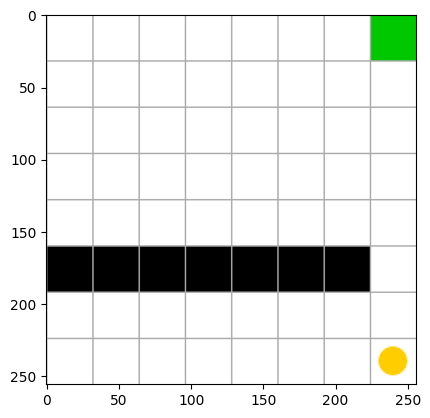

In [5]:
ENV = EnvFactory.Grid_2D_8x8_discrete

# Grid configuration
OBSTACLE = obstacle_selected.value
INITIAL_STATE = (7, 7)
FINAL_STATE = (0, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = ENV.get_env(render_mode=render_mode, grid_config=env_2D_grid_initial_config)

snapshot_env(env)

### STEP 2: Create Minari datasets

**Behavior policies and datasets configurations**

In [6]:
BEHAVIOR_POLICY_I = BehaviorPolicy2dGridFactory.move_up
DATA_SET_IDENTIFIER_I = "_expert"
NUM_STEPS_I = 1000

BEHAVIOR_POLICY_II = BehaviorPolicy2dGridFactory.move_left
DATA_SET_IDENTIFIER_II = "_suboptimal"
NUM_STEPS_II = 2000

In [7]:
policy_selected = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

Dropdown(options=(<BehaviorPolicy2dGridFactory.move_up: 'move_up'>, <BehaviorPolicy2dGridFactory.move_left: 'm…

In [8]:
offpolicy_rendering(
    env_or_env_name=ENV,
    render_mode=render_mode,
    behavior_policy=policy_selected.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
)

**Collect data**

In [9]:
from offline_rl.generate_custom_minari_datasets.generate_minari_dataset import (
    create_combined_minari_dataset,
)

config_combined_data = create_combined_minari_dataset(
    env_name=ENV,
    dataset_identifiers=(DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
    num_collected_points=(NUM_STEPS_I, NUM_STEPS_II),
    behavior_policies=(BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
    combined_dataset_identifier="combined_data_sets_offline_rl",
    env_2d_grid_initial_config=env_2D_grid_initial_config,
)

dataset_availables = [
    config_combined_data.data_set_name
] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

Number of episodes in dataset I:20, in dataset II:40 and  in the combined dataset: 60


Dropdown(options=('Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0', 'Grid_2D_8x8_discrete-data_obstacle…

### STEP 3: Feed data into replay buffer

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0 downloaded. number of episodes: 60


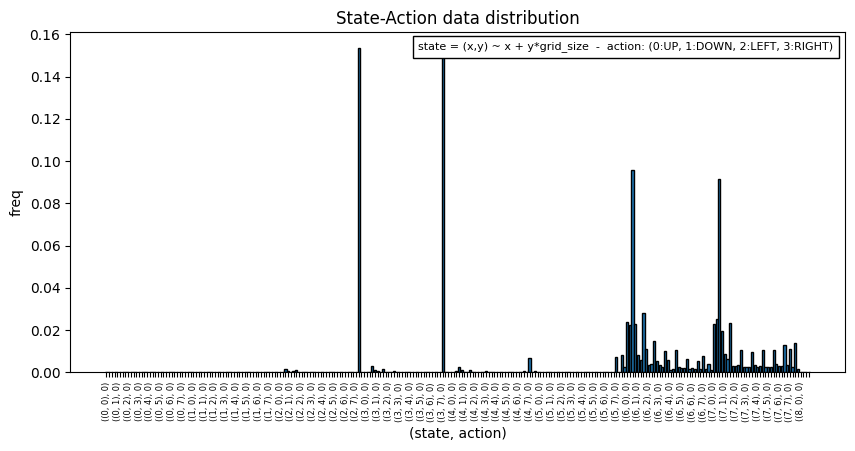

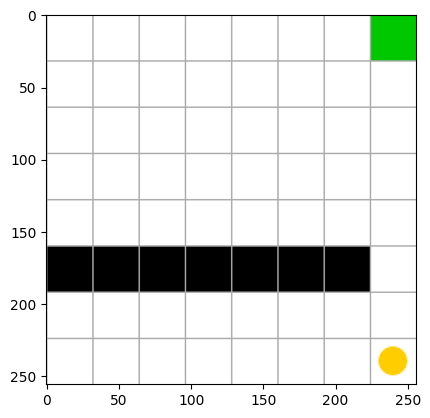

In [10]:
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
snapshot_env(env)

#### Data analysis

Note that we have four peaks. The ones at (2,7) and (3,7) come from policy-I, which goes towards the target but stops before reaching it. The other two peaks at (6,0) and (7,0) are produced by policy-II, which drifts the agent to the left with noise. **It is important to notice that the amount of collected data at state (5,7) is very little, but this state is crucial if we want to approach the target.**

What do you think a BC algorithm would do? What about an offline one?

<div style="margin-top: 20px;">
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 100%;">
            <img src="_static/images/nb_96_critical_state.png" alt="Snow" style="width:100%;">
        </div>
        <div style="width: 100%;">
            <img src="_static/images/96_critical_action_states.png" alt="KL divergence" width=80%>
        </div>
    </div>
</div>

### STEP 4-5: Select offline policies and training

In [11]:
from offline_rl.offline_policies.policy_registry import RLPolicyFactory

offline_rl_policies = [
    RLPolicyFactory.bcq_discrete,
    RLPolicyFactory.cql_discrete,
    RLPolicyFactory.imitation_learning,
]
selected_offline_rl_policy = widget_list(offline_rl_policies)

Dropdown(options=(<RLPolicyFactory.bcq_discrete: 'bcq_discrete'>, <RLPolicyFactory.cql_discrete: 'cql_discrete…

**Training**

In [12]:
NUM_EPOCHS = 2
BATCH_SIZE = 128
STEP_PER_EPOCH = 1.0 * len_buffer
NUMBER_TEST_ENVS = 1

# Metadata for the offline policy. Included the Minari metadata as well as the policy model configuration.
offline_policy_config = TrainedPolicyConfig(
    rl_policy_model=selected_offline_rl_policy.value,
    name_expert_data=selected_data_set.value,
    render_mode=render_mode,
    device="cpu",
)

# Hyperparameters to be used in the training.
offline_training_hyperparams = OfflineTrainingHyperparams(
    offline_policy_config=offline_policy_config,
    num_epochs=NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
)

In [13]:
OfflineRLTraining.training(
    offline_training_hyperparams,
    show_progress=IS_NOT_CI 
)

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0 downloaded. number of episodes: 60


Epoch #1: test_reward: -43.090235 ± 0.000000, best_reward: -43.090235 ± 0.000000 in #1


Epoch #2: test_reward: -0.207813 ± 0.000000, best_reward: -0.207813 ± 0.000000 in #2


**Restore and visualize trained policy**

In [14]:
available_obstacles = [ObstacleTypes.obstacle_8x8_wall_with_door]
selected_obstacle = widget_list(available_obstacles)

Dropdown(options=(<ObstacleTypes.obstacle_8x8_wall_with_door: ['00000000', '00000000', '00000000', '00000000',…

In [15]:
# SAVED_POLICY_NAME = "policy_best_reward.pth"
SAVED_POLICY_NAME = "policy.pth"
INITIAL_STATE = (7, 7)
FINAL_STATE = (0, 7)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    rl_policy_model=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu",
)

policy = OfflineRLTraining.restore_policy(offline_policy_config)

env.set_new_obstacle_map(selected_obstacle.value.value)
env.set_starting_point(INITIAL_STATE)
env.set_goal_point(FINAL_STATE)
# snapshot_env(env)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
    imitation_policy_sampling=False,
    inline=True,
)

### Summary and conclusions

**BCQ and the CQL policies are able to learn the expert data**

**Imitation learning cannot make it because it cannot learn the critical state-action pairs.**

## Exercise II 

**Now, we'll explore how BCQ and CQL, address the issue of connecting suboptimal trajectories in order to get new ones with higer rewards (stitching property). We will see how they compare with imitation learning.**

We will start again with the previous setup. So, as we did before, we will create again two datasets: one from a policy moving suboptimal from (0,0) to (2,4), and the other from another policy moving from (4,0) to (7,7). The goal is to find an agent capable of connecting trajectories coming from both datasets, in order to find the optimal path between (2,0) and (2,4).

### STEP 1: Create the environment

**Create the environment**

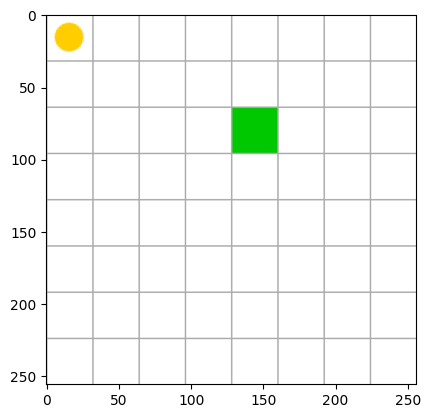

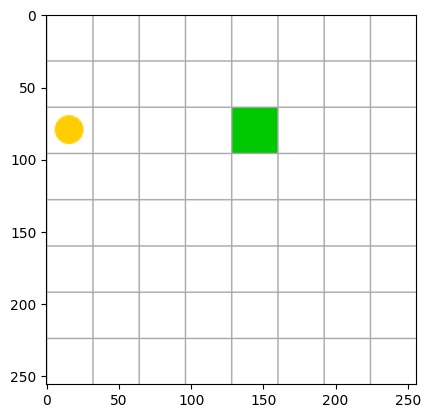

In [16]:
ENV = EnvFactory.Grid_2D_8x8_discrete

OBSTACLE = ObstacleTypes.obst_free_8x8
INITIAL_STATE_POLICY_I = (0, 0)
INITIAL_STATE_POLICY_II = (2, 0)
FINAL_STATE_POLICY = (2, 4)


env_2D_grid_initial_config_I = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE_POLICY_I,
    target_state=FINAL_STATE_POLICY,
)

env_2D_grid_initial_config_II = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE_POLICY_II,
    target_state=FINAL_STATE_POLICY,
)

env = ENV.get_env(render_mode=render_mode, grid_config=env_2D_grid_initial_config_I)
snapshot_env(env)

env = ENV.get_env(render_mode=render_mode, grid_config=env_2D_grid_initial_config_II)
snapshot_env(env)

### STEP 2: Create Minari datasets

**Let's see how well offline RL algorithms can deal with the stitching property. We will examine some edge cases to compare them with some of the algorithms we have already studied before.**

In [17]:
IDENTIFIER_COMBINED_DATASETS = "_stiching_property_I"

# Dataset I with 2000 collected points
BEHAVIOR_POLICY_I = BehaviorPolicy2dGridFactory.deterministic_8x8
DATA_SET_IDENTIFIER_I = "_longer_path"
NUM_STEPS_I = 2000

# Dataset II with 1000 points
# BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_eps_greedy_4_0_to_7_7
BEHAVIOR_POLICY_II = BehaviorPolicy2dGridFactory.move_right
DATA_SET_IDENTIFIER_II = "_short_path"
NUM_STEPS_II = 1000

In [18]:
select_policy_to_render = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

Dropdown(options=(<BehaviorPolicy2dGridFactory.deterministic_8x8: 'deterministic_8x8'>, <BehaviorPolicy2dGridF…

In [19]:
env_2D_grid_initial_config = (
    env_2D_grid_initial_config_I
    if select_policy_to_render.value == BEHAVIOR_POLICY_I
    else env_2D_grid_initial_config_II
)

offpolicy_rendering(
    env_or_env_name=ENV,
    render_mode=render_mode,
    policy_model=select_policy_to_render.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
)

**Create datasets**

In [20]:
config_combined_data = create_combined_minari_dataset(
    env_name=ENV,
    dataset_identifiers=(DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
    num_collected_points=(NUM_STEPS_I, NUM_STEPS_II),
    behavior_policies=(BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
    combined_dataset_identifier="combined_dataset",
    env_2d_grid_initial_config=(env_2D_grid_initial_config_I, env_2D_grid_initial_config_II),
)
buffer_data = load_buffer_minari(config_combined_data.data_set_name)
data_size = len(buffer_data)

Number of episodes in dataset I:125, in dataset II:250 and  in the combined dataset: 375
Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 375


In [21]:
dataset_availables = [
    config_combined_data.data_set_name
] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

Dropdown(options=('Grid_2D_8x8_discrete-combined_dataset-v0', 'Grid_2D_8x8_discrete-data_obst_free_8x8_start_0…

### STEP 3: Feed data into replay buffer

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 375


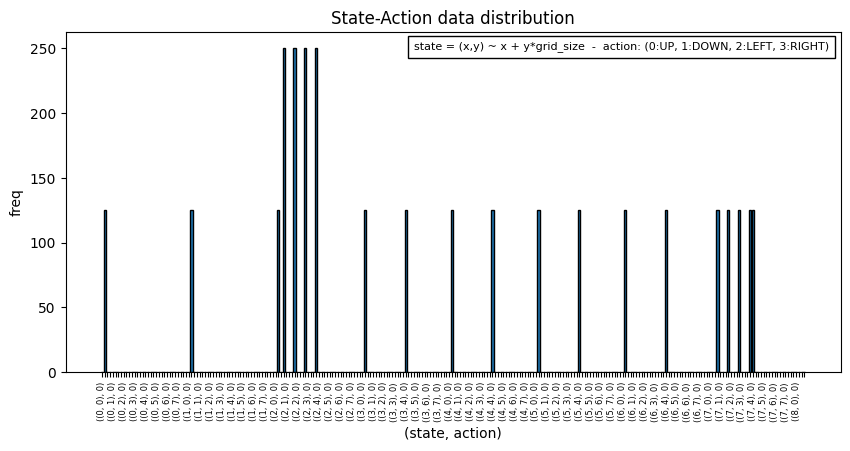

In [22]:
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(
    buffer_data, env, normalized=False
)

if "start_0_0" in selected_data_set.value:
    env.set_starting_point((0, 0))
    snapshot_env(env)
elif "start_2_0" in selected_data_set.value:
    env.set_starting_point((2, 0))
    snapshot_env(env)

### STEP 4: Select offline policies and training

In [23]:
offline_rl_policies = [RLPolicyFactory.bcq_discrete, RLPolicyFactory.cql_discrete]
selected_offline_rl_policy = widget_list(offline_rl_policies)

Dropdown(options=(<RLPolicyFactory.bcq_discrete: 'bcq_discrete'>, <RLPolicyFactory.cql_discrete: 'cql_discrete…

In [24]:
# Offiline - Training

NUM_EPOCHS = 2
BATCH_SIZE = 128
STEP_PER_EPOCH = 1.0 * len_buffer
NUMBER_TEST_ENVS = 1


offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    rl_policy_model=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu",
)


# Hyperparameters to be used in the training.
offline_training_hyperparams = OfflineTrainingHyperparams(
    offline_policy_config=offline_policy_config,
    num_epochs=NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
)

In [25]:
OfflineRLTraining.training(
    offline_training_hyperparams,
    show_progress=IS_NOT_CI
)

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 375


Epoch #1: test_reward: -0.022067 ± 0.000000, best_reward: -0.022067 ± 0.000000 in #1


Epoch #2: test_reward: -0.022067 ± 0.000000, best_reward: -0.022067 ± 0.000000 in #1


**Restore and visualize trained policy**

In [26]:
# SAVED_POLICY_NAME = "policy_best_reward.pth"
SAVED_POLICY_NAME = "policy.pth"
INITIAL_STATE = (0, 0)
FINAL_STATE = (2, 4)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    rl_policy_model=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu",
)

policy = OfflineRLTraining.restore_policy(offline_policy_config)
log_name = Path(selected_data_set.value) / Path(selected_offline_rl_policy.value)
log_path = get_trained_policy_path() / log_name / SAVED_POLICY_NAME
policy.load_state_dict(torch.load(str(log_path), map_location="cpu"))

env.set_starting_point(INITIAL_STATE)
env.set_goal_point(FINAL_STATE)
# snapshot_env(env)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
    imitation_policy_sampling=False,
)

**Question**: Let's now change the dataset distribution. We'll collect 600 points with the first behavior policy and 100 with the second one. In this case, the probability of taking the suboptimal path will be higher. What paths are chosen by the algorithms?

## Final remarks

Offline RL proves valuable in various scenarios, especially when:

a. Robots require intelligent behavior in complex open-world environments demanding extensive training data due to robust visual perception requirements. (complex environment modeling and extensive data collection)

b. Robot grasping tasks, which involve expert data that cannot be accurately simulated, providing an opportunity to assess our BCQ algorithm.

c. Robotic navigation tasks, where offline RL aids in crafting effective navigation policies using real-world data.

d. Autonomous driving, where ample expert data and an offline approach enhance safety.

e. Healthcare applications, where safety is paramount due to the potential serious consequences of inaccurate forecasts.

... and many more.

However, if you have access to an environment with abundant data, online Reinforcement Learning (RL) can be a powerful choice due to its potential for exploration and real-time feedback. Nevertheless, the landscape of RL is evolving, and a data-centric approach is gaining prominence, exemplified by vast datasets like X-Embodiment. It's becoming evident that robots trained with diverse data across various scenarios tend to outperform those solely focused on specific tasks. Furthermore, leveraging multitask trained agents for transfer learning can be a valuable strategy for addressing your specific task at hand.